# Dimensionality reduction on NBA player data.

In [180]:
#Import Packages

import pandas as pd
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist as pdist
from scipy.spatial.distance import squareform as squareform

from matplotlib.pyplot import title as title
from mpl_toolkits.mplot3d import Axes3D as Axes3D
from matplotlib.pyplot import scatter as scatter
from matplotlib.pyplot import savefig as savefig

## Use the below for other matplotlib options
#%matplotlib inline
%matplotlib qt
#%matplotlib notebook

# Pandas data frame.  A pretty way to represent tabular data.

In [5]:
df = pd.read_csv('data/stats.csv')
df;

# Queries.  They're nice in pandas

In [117]:
# Joel Embiid?
df.query("name == 'Joel Embiid'");

In [118]:
# More than 1 block per game?
df.query("blk_per_g > 1");

In [119]:
# gs fewer than 50?
df.query("gs< 50");

## [pandas <----> numpy] functions 

In [9]:
''' For the following functions, "df" is a pandas data frame.
    Function "return_data_mat" turns the data frame into numpy array with player name column removed.
    Function "return_names" returns the names column of the players.
'''

def return_data_mat(df):
    vals = df.values
    trimvals = vals[:,1:]
    data_mat = trimvals.astype(float)
    return data_mat

def return_names(df):
    vals = df.values
    names = (vals[:,0]).astype('str')
    return names

# Plots of data after pre-processing (dimensionality reduction)

<IPython.core.display.Javascript object>


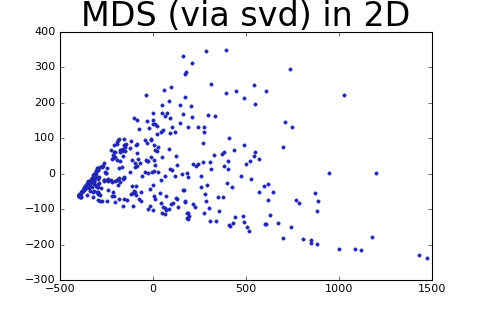

In [185]:
plot_dim_redux(df, 'MDS', 'svd', threeD = False)

<IPython.core.display.Javascript object>


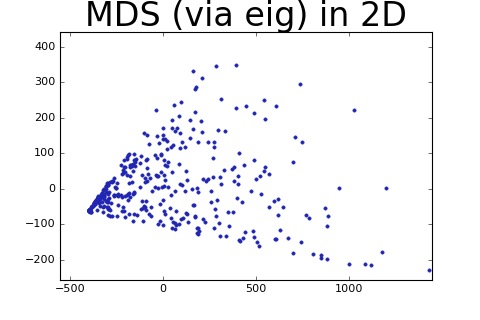

In [186]:
plot_dim_redux(df, 'MDS', 'eig', threeD = False)

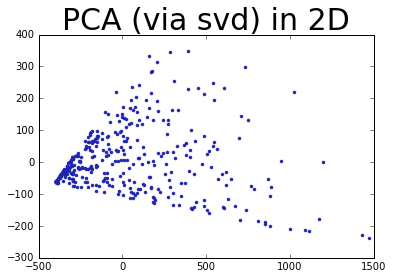

In [111]:
plot_dim_redux(df, 'PCA', 'svd', threeD = False)

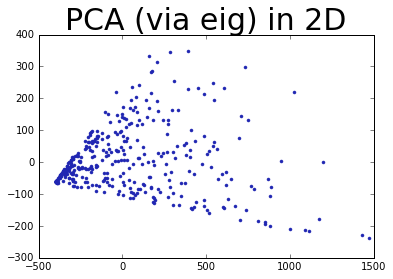

In [112]:
plot_dim_redux(df, 'PCA', 'eig', threeD = False)

<IPython.core.display.Javascript object>


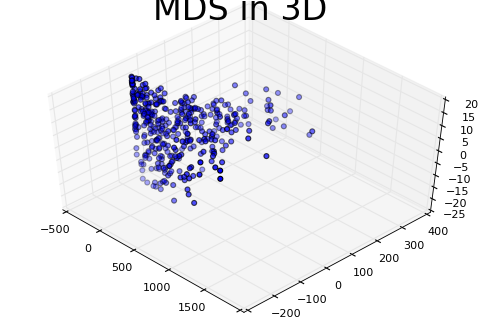

In [191]:
plot_dim_redux(df, 'MDS', 'svd', threeD = True)

<IPython.core.display.Javascript object>


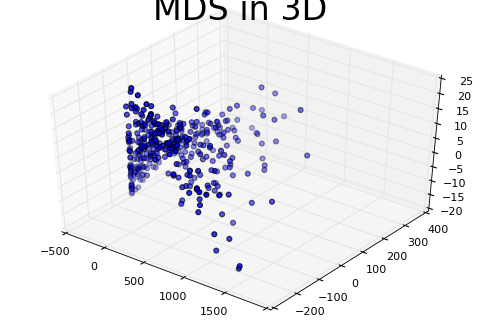

In [190]:
plot_dim_redux(df, 'MDS', 'eig', threeD = True)

 # Plotting function

In [169]:
# Plotting function

def plot_dim_redux(data_frame, method, procedure, text = False, threeD = False):
    
    #Get the data matrix
    data = return_data_mat(data_frame)
    
    #Get new data based off of Dimensionality reduction method
    if method == 'PCA':
        new_data = PCA(data, procedure)
        
    if method == 'MDS':
        new_data = MDS(data, procedure)
        
    #Get data columns and the names column
    new_data = new_data.A
    col1 = new_data[:, 0]
    col2 = new_data[:, 1]
    col3 = new_data[:, 2]
    names = return_names(data_frame)
    
#     print type(col1), type(col2), type(col3)
    
    #2D Plot
    if threeD == False:
        clr1 =  '#2026B2'
        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.plot(col1, col2, '.', mfc=clr1, mec=clr1)
        #Use Players names in the plot
        if text == True:
            for i in range(len(col1)):
                plt.text(col1[i], col2[i], names[i], fontsize=10)
        title(method + ' (via ' + str(procedure) + ')' + ' in 2D', fontsize=30)
        plt.show()
   
    #3D Plot    
    elif threeD == True:
        ax = Axes3D(plt.figure())
        ax.scatter(col1, col2, col3, s=20, cmap='jet')
        title(method + ' in 3D', fontsize=30)
        plt.show()  

# Helper functions

In [189]:
# # HELPER FUNCTIONS

def flip(X, col_number):
    ''' X is an array with two axes.
        flips all values in a given column
        remember columns are 0-indexed'''
    for i in range(X.shape[0]): #for every row
        X[i, col_number] = - (X[i, col_number]) #flip value
    return X 

def get_distance_matrix(X):
    D = squareform(pdist(X, 'euclidean'))
    return D

def test_PCA(data, new_dims=2):
    '''
    test by attempting to recover original data array from
    the eigenvectors of its covariance matrix & comparing that
    'recovered' array with the original data
    '''
    _ , F = PCA(data, 'eig')
    X = PCA(data, 'svd')
    data_recovered = np.matrix(X) * F
    data_recovered += data_recovered.mean(axis=0)
    assert np.allclose(data, data_recovered)

# PCA function

In [188]:
# # PCA function
    
def PCA(data, procedure, new_dims=4):
    """
    returns: X: data transformed (projected to principal component axes)
    pass in: 
        data as 2D NumPy array. data points are rows. variables are columns.
        procedure. either svd or eigendecomposition.
        new_dims (optional). size out output matrix. number of dims in rescale.
    """
    #data matrix and shape
    data = np.matrix(data)
    m, n = data.shape
    
    #centering matrix z  
    z = np.matrix(np.zeros((m, n)))
    colmeans = data.mean(axis=0)
    for i in range(m):
        z[i, :] = colmeans    
        
    #mean centered        
    data_c = data - z
        
    if (procedure == 'svd'):
    
        # # BELOW: SVD method    
        # # get u and svals
        u, svals, v = linalg.svd(data_c, full_matrices = False) # run an svd on (should it be centered?) data
        
        #handle sign ambiguity in SVD
        for i in range(len(svals)):
            svals[i] = abs(svals[i])
            
        # sort s and u in decreasing order
        idx_ascending = np.argsort(svals)
        idx = idx_ascending[::-1]
        svals = svals[idx]
        u = u[:,idx]  
        
        #trim to new dimension size
        svals = svals[0:new_dims] #trim s values
        s = np.diag(svals)  # make s matrix
        u = u[:, 0:new_dims] # trim u values

        # create score matrix X = US and return it
        X = np.matrix(u) * np.matrix(s)
        return X
    
    if (procedure == 'eig'):
    
        ## BELOW: eigendecomposition method.    
        # calculate the covariance matrix
        #R = (1/m) * (data_c.T * data_c)
        R =np.cov(data, rowvar=False)

        # calculate eigenvectors & eigenvalues of the covariance matrix
        evals, evecs = linalg.eigh(R)   # use 'eigh' rather than 'eig' since R is symmetric 

        # sort eigenvalues/eigenvectors in decreasing order
        idx_ascending = np.argsort(evals)
        idx = idx_ascending[::-1]
        evals = evals[idx]
        evecs = evecs[:,idx]

        # select the first n eigenvectors (n is desired dimension of rescaled data)
        transform_evecs = evecs[:, :new_dims]

        # carry out the transformation on the data using eigenvectors matrix
        X = np.matrix(data_c) * np.matrix(transform_evecs)
        
        X = flip(X,0)
        X = flip(X,1)
 
        return X #, np.matrix(transform_evecs) 
    
### These functions assisted by this link:
# http://stackoverflow.com/questions/13224362/principal-component-analysis-pca-in-python

# MDS Function

In [187]:
# # MDS function
    
def MDS(data, procedure, new_dims = 4):
    
    """
    returns: X: data transformed
    pass in: 
        data as 2D NumPy array. data points are rows. variables are columns.
        procedure. either svd or eigendecomposition, for gram matrix B.
        new_dims (optional). size out output matrix. number of dims in rescale.
    """
    
    # # get squared proximity matrix
    D = get_distance_matrix(data)
    D2 = np.power(D, 2)
    n = D2.shape[0]
    
    # # create centering matrix
    I = np.eye(n) # identity matrix
    my_ones = np.ones((n,n)) # matrix of all ones
    my_ones = (float(1) / float(n)) * my_ones # divided by n
    C = I - my_ones # C is centering matrix
    
    # # apply double centering to get inner product matrix
    B = (float(-1) / float(2)) * np.matrix(C) * np.matrix(D2) * np.matrix(C)
    
    if (procedure == 'svd'):
    
        # # BELOW: SVD method    
        # # get u and svals
        u, svals, v = linalg.svd(B, full_matrices = False) # run an svd on (should it be centered?) data

        #handle sign ambiguity in SVD
        for i in range(len(svals)):
            svals[i] = abs(svals[i])

        # sort s and u in decreasing order
        idx_ascending = np.argsort(svals)
        idx = idx_ascending[::-1]
        svals = svals[idx]
        u = u[:,idx]  

        #trim to new dimension size
        svals = svals[0:new_dims] #trim s values
        s = np.diag(svals)  # make s matrix
        s = np.power(s, .5)  #take square root
        u = u[:, 0:new_dims] # trim u values


        # create score matrix X = US and return it
        X = np.matrix(u) * np.matrix(s)

        X = flip(X,0)
        X = flip(X,1)
    

    if (procedure == 'eig'):

        ## BELOW: eigendecomposition method.    
        # calculate eigenvectors & eigenvalues of the gram matrix B
        evals, evecs = linalg.eigh(B)   # use 'eigh' rather than 'eig' since R is symmetric 

        # sort eigenvalues/eigenvectors in decreasing order
        idx_ascending = np.argsort(evals)
        idx = idx_ascending[::-1]
        evals = evals[idx]
        evecs = evecs[:,idx]
        
        #trim to new dimension size
        evals = evals[0:new_dims] #trim  eigenvalues
        ediag = np.diag(evals)  # make eigendiag matrix
        s = np.power(ediag, .5)  #take square root to get s
        u = evecs[:, 0:new_dims] # trim evecs to get the u desired


        # create score matrix X = US and return it
        X = np.matrix(u) * np.matrix(s)

        #this section below helps to be same as PCA in 2D. Not sure if necessary yet.
        X = flip(X,0)
        X = flip(X,1)
           
#     #this part handles negatives I think?
#     for i in range(new_X.shape[1]):
#         if new_X[0,i] < 0:
#             for j in range(new_X.shape[0]):
#                 new_X[j, i] = -new_X[j, i]
                
    
    #return value
    return X 